## Homework 1 - Finding similar items

## Shingling / Shingles

> **Lab description**: *A class Shingling that constructs k–shingles of a given length k (e.g., 10) from a given document, computes a hash value for each unique shingle and represents the document in the form of an ordered set of its hashed k-shingles.*

The first part of this homework is to implement the shingling algorithm. The shingling algorithm takes a document and breaks it into a set of k-shingles. For example, if we have the document "Hello World" and we use a k-shingle size of 3, we would get the following shingles:
```bash
    {Hel, ell, llo, lo ,o W, Wo, or, rl, ld}
```
The shingling algorithm is implemented in the `shingling` class. The function takes a document and a k-shingle size and returns a set of shingles. The function is implemented in the cell below.

Notable details of our implementation:
- We use Python's native hash function to compute the hash value of each shingle and modulo max value of an unsigned int $(2^32 - 1)$.
- We use a set to store the shingles, which is a data structure that only stores unique elements. This is useful because we don't want to store duplicate shingles. It also allows for convinient set operations later on.


In [19]:
class Shingling:
  def __init__(self, text, k):
    self.shingles = self.constructShingles(text, k)
    self.hashed_shingles = self.constructHashedShingles(text, k)

  def constructShingles(self, s, k=5):
    """
    Split a (lower case) string into k equal sizes.
    """
    return set([s[i:(i+k)].lower() for i in range(0, len(s)-k+1)])

  def constructHashedShingles(self, text, k=5, hashBoundary=((2**32)-1)):
    """
    Using above function to construct shingles, and then hash them.
    """
    shingles = self.constructShingles(text, k)
    hashed_shingles = [hash(shingle) % hashBoundary for shingle in shingles]
    return set(hashed_shingles)


By using the examples provided in the lecture (`factorial` vs `editorial`), we demonstrate our `Shingling` class in the next cell.

In [20]:
# examples from lecture
editorial = "editorial"
factorial = "factorial"

shingle_length = 5

shingling_editorial = Shingling(editorial, shingle_length)
shingling_factorial = Shingling(factorial, shingle_length)

shinglings = [shingling_editorial, shingling_factorial]

print("Shingles for editorial: ", shinglings[0].shingles)
print("Shingles for factorial: ", shinglings[1].shingles)
print("Matching: ", shinglings[0].shingles & shinglings[1].shingles)

print("\nHashed shingles for editorial: ", shinglings[0].hashed_shingles)
print("Hashed shingles for factorial: ", shinglings[1].hashed_shingles)
print("Matching: ", shinglings[0].hashed_shingles & shinglings[1].hashed_shingles)

Shingles for editorial:  {'orial', 'ditor', 'edito', 'itori', 'toria'}
Shingles for factorial:  {'facto', 'orial', 'actor', 'ctori', 'toria'}
Matching:  {'toria', 'orial'}

Hashed shingles for editorial:  {2045878978, 3516216712, 786809002, 1523537460, 112851898}
Hashed shingles for factorial:  {3131635656, 786809002, 856325643, 400798385, 1523537460}
Matching:  {786809002, 1523537460}


## Compare Sets

> **Lab description:** *A class CompareSets computes the Jaccard similarity of two sets of integers – two sets of hashed shingles.*

The next part of this homework is to implement the Jaccard similarity. Since we implements Shingles with Python sets, we can use Python's built-in set operations. To this end it is sufficent to use `&` and `|`. The `CompareSets` class is implemented in the cell below.

In [21]:
import numpy as np

class CompareSets:

  def similarity(sel, A, B):
    """
    Jaccardi similarity between two sets of hashed shingles.
    """
    return len(A & B) / len(A | B)

  def distance(self, A, B):
      """
      Jaccardi distance.
      """
      return 1-self.similarity(A, B)

Now we demonstrate the class by comparing the shingles of `factorial` and `editorial`.

In [22]:
# create a new 'compare' object
comparer = CompareSets()
similarity = comparer.similarity(A=shingling_editorial.hashed_shingles, 
                                 B=shingling_factorial.hashed_shingles)

print('Jaccardi Similarity:', similarity)

Jaccardi Similarity: 0.25


## MinHashing

> **Lab description**: *A class MinHashing that builds a minHash signature (in the form of a vector or a set) of a given length n from a given set of integers (a set of hashed shingles).*

The next part of this homework is to implement the MinHashing algorithm. We make a MinHashing class that takes a set of shingles and a returns a signature. The class is implemented in the cell below.
Notable details of our implementation:
- We have a method to construct the *characteristic matrix* and two different implementations of finding the signature matrix.
    * `createSigMatPer` requries the characteristic matrix to be constructed and then finds the signature matrix by using permutations. It is slow and less space efficent.
    * `createSigMatHash` finds the signature matrix *without* constructing the characteristic matrix. It is faster and more space efficent.
- We use a hash function on the form of $ax+b \mod N$, where $a$ and $b$ are random numbers ($a, b < 2^{32}-1$) and $N$ is the prime number closest to, and greater than, $2^{32}-1$ (found by table of known prime numbers).

In [23]:
import numpy as np

class MinHashing:

  def constructCharMat(self, shingleList):
    union = set().union(*shingleList)
    return np.array([[int(e in s) for s in shingleList] for e in union])

  def createSigMatPer(self, shingleList, K=100):
    charMat = self.constructCharMat(shingleList)
    sigMat = []
    
    for i in range(K):
      perCharMat = np.take(charMat, np.random.RandomState(seed=i).permutation(charMat.shape[0]),axis=0)
      sigMatRow = [np.where(col == 1)[0][0] for col in perCharMat.T]
      sigMat.append(sigMatRow)

    return np.array(sigMat)

  def createSigMatHash(self, shingleList, K=100):
    # assign max value to use as boundary when finding a and b
    max_int = 2**32-1
    # a prime number larger than max_int, but still not too large
    prime = 4294967311

    # generate K random a and b values, bounded by maxID
    a = self.getHashCoefficients(upper_bound=max_int, K=K, seed=1)
    b = self.getHashCoefficients(upper_bound=max_int, K=K, seed=2)

    # create the signature matrix of size K x len(setList) by hashing each set and finding the minum value
    # TODO parallellize this?
    sigMat = np.array([[np.min([(a[i] * e + b[i]) % prime for e in s]) for s in shingleList] for i in range(K)])
    return sigMat
     
  def getHashCoefficients(self, upper_bound, K=100, seed=1):
    return np.random.RandomState(seed=seed).randint(low=0, high=upper_bound, size=K, dtype=np.uint32)




Below we demonstrate our implementation of the signature matrix by comparing the signatures of `factorial` and `editorial`.

In [24]:
import pandas as pd
# store the shingles in a list for convenience
shingles = [shingling_editorial.shingles, shingling_factorial.shingles]

# find their union (also called 'document vector space')
union = set().union(*shingles)

# create a new minhash object
minHash = MinHashing()

# construct the characteristic matrix
charMat = minHash.constructCharMat(shingles)

# Out of courtesy, we mask the output of 'charMat' as a Panda dataframe
pd.DataFrame(charMat, index=list(set().union(*shingles)), columns=['\"Editorial\"', '\"Factorial\"'])


,"""Editorial""","""Factorial"""
facto,0,1
orial,1,1
actor,0,1
ditor,1,0
edito,1,0
itori,1,0
ctori,0,1
toria,1,1


Here we compare the signatures of `factorial` and `editorial` using the `createSigMatHash` method. The rows are enumerated hash functions, and the columns are the documents.

In [25]:
hashed_shingles = [shingling_editorial.hashed_shingles, shingling_factorial.hashed_shingles]
union = union = set().union(*hashed_shingles)

# NOTE: as number of hash functions increases, the similarity converges to the true similarity
number_of_hash_functions = 100
sigMat = minHash.createSigMatHash(hashed_shingles, K=number_of_hash_functions)

# signature matrix is a (number of hash functions) x (number of documents) matrix
df = pd.DataFrame(sigMat, columns=['\"Editorial\"', '\"Factorial\"'])
df.index.name = 'Hash function #'
df

,"""Editorial""","""Factorial"""
Hash function #,,
0,1301443494,625465253
1,200381731,215242056
2,2051311986,983940
3,184034005,184034005
4,923525835,6961639
...,...,...
95,2327052499,2527611667
96,356954214,889943588
97,1531581531,61919623


Since we employed two different methods to find the signature matrix, we can compare the two methods. For `editorial` vs `factorial`, the approach using hash functions has a speed-up of ~4.5x. It makes sense, because the latter approach does not require the construction of the characteristic matrix.

In [26]:
# store the shingles in a list for convenience
shingles = [shingling_editorial.hashed_shingles, shingling_factorial.hashed_shingles]
union = set().union(*shingles)

# setup matrices
minHash = MinHashing()
charMat = minHash.constructCharMat(shingles)
number_of_hash_functions = 100

# ----- Creating Signature Matrix with Permutations -----
print("Creating Signature Matrix with Permutations and K =", number_of_hash_functions)
%timeit minHash.createSigMatPer(shingles, number_of_hash_functions)

# ----- Creating Signature Matrix with Hashing -----
print("\nCreating Signature Matrix with Hashing and K =", number_of_hash_functions)
%timeit minHash.createSigMatHash(shingles, number_of_hash_functions)

Creating Signature Matrix with Permutations and K = 100
17.5 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Creating Signature Matrix with Hashing and K = 100
4.79 ms ± 48.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Compare Signatures

> **Lab description**: *A class CompareSignatures estimates the similarity of two integer vectors – minhash signatures – as a fraction of components in which they agree.*

We made a short class to compare the signatures of two columns of a signature matrix. The class is implemented in the cell below.

In [27]:
import numpy as np

class CompareSignatures:
  def similarity(self, document1, document2):
    return (np.sum(document1 == document2)) / len(document1)

We demonstrate the class by comparing the signatures of `factorial` and `editorial`. The documents are too small for any significant difference to be observed between permutations and hash functions.

In [28]:
# set up the comparer and signuture matrices of type 1) permutations, 2) hash functions
signature_comparer = CompareSignatures()
number_of_hash_functions = 100
signature_permutations = minHash.createSigMatPer(shingles, number_of_hash_functions)
signature_hash_functions = minHash.createSigMatHash(shingles, number_of_hash_functions)

print('Signature Matrix Similarity Permutation:', signature_comparer.similarity(signature_permutations[:,0], signature_permutations[:,1]))
print('Signature Matrix Similarity Hash:', signature_comparer.similarity(signature_hash_functions[:,0], signature_hash_functions[:,1]))

Signature Matrix Similarity Permutation: 0.25
Signature Matrix Similarity Hash: 0.26


## Locality-Sensitive Hashing

> **Lab description:** *A class LSH that implements the LSH technique: given a collection of minhash signatures (integer vectors) and a similarity threshold t, the LSH class (using banding and hashing) finds candidate pairs of signatures agreeing on at least a fraction t of their components.*

The next part of this homework is to implement the LSH algorithm. We make a LSH class that takes a signature matrix and a similarity threshold and returns a list of candidate pairs. The class is implemented in the cell below.

#### Breif explanation of the LSH algorithm
 Since the vocabulary is large, and we have to compare each document pairwise, the amount of comparisons required is (N choose 2), where N is the number of documents. This is a lot of comparisons. We want to reduce the number of comparisons by locating candidate pairs that are similar. To this end, we use LSH. We divide the signature matrix into bands, and for each band we hash the rows. If two rows have the same hash value, they are likely to be similar. We then compare the rows pairwise. The class is implemented in the cell below.

According to the course litterature, we assume that two slices of a given column (row = *document*) are candidate pairs if and only if they have identical elements. Thus, we don't have to implement a particular hash functions, but can use Python's. Frozen sets are a hashable data structure in Python that ensure that the hash value is independent of the order of the elements.

In [29]:
import numpy as np

class LSH:

  def estimateBandR(self, sigMat, simThresh=0.8):
    # rangeMax = int(len(sigMat)/math.log(len(sigMat)))
    rangeMax = len(sigMat)
    brSolutions = [[b,r] for b in range(rangeMax) for r in range(rangeMax) if (b * r)==len(sigMat)]

    similarities = [(1/ab[0])**(1/ab[1]) for ab in brSolutions]

    closestFit = min(similarities, key=lambda x:abs(x-simThresh))
    index = similarities.index(closestFit)
    return brSolutions[index][0], brSolutions[index][1]

  def findCandidatePairs(self, sigMat, threshold=0.80, bands=None, k=10**6):

    if bands is None:
      b, r = self.estimateBandR(sigMat, threshold)

    # assume that the number of rows is evenly divisible by the number of bands
    assert len(sigMat) % b == 0

    candidate_pairs = []

    for i in range(sigMat.shape[1]):
      for j in range(sigMat.shape[1]):
        if i == j:
          continue
        
        for n in range(b):
          # use frozen sets since it is hashable
          hashBand1 = hash(frozenset(sigMat[n*r:(n+1)*r,i])) % k
          hashBand2 = hash(frozenset(sigMat[n*r:(n+1)*r,j])) % k

          if hashBand1 == hashBand2:
            # print((i,j))
            if (i,j) not in candidate_pairs and (j,i) not in candidate_pairs:
              candidate_pairs.append((i,j))
              # print((i,j))
            break

    print(sigMat.shape[1], 'documents have', len(candidate_pairs), 'candidate pairs')
    print(b, 'bands and', r, 'rows per band')
    print('Estimated similarity threshold:', (1/b)**(1/r))
    return candidate_pairs


In [30]:
lsh = LSH()
threshold = 0.1
print('Estimated number of bands and rows per band:', lsh.findCandidatePairs(signature_hash_functions, threshold=threshold))



2 documents have 1 candidate pairs
50 bands and 2 rows per band
Estimated similarity threshold: 0.1414213562373095
Estimated number of bands and rows per band: [(0, 1)]


## Testing

We now test our implementation with "real-world" data.

In [31]:
textMinHashGuide = 'In this post, Im providing a brief tutorial, along with some example Python code, for applying the MinHash algorithm to compare a large number of documents to one another efficiently. I first learned about this topic through Stanfords Mining of Massive Datasets (“MMDS”) course available for free on Coursera here (Update 11/5/19 - Its no longer on Coursera, but still freely available here). Whats especially great about that course is that the authors also provide their textbook online for free! You can find the textbook here, with a separate PDF file for each chapter. Chapter 3 covers the MinHash algorithm, and Id refer you to that text as a more complete discussion of the topic. On to the tutorial! There is an interesting computing problem that arises in a number of contexts called “set similarity”. Lets say you and I are both subscribers to Netflix, and weve each watched roughly 100 movies on Netflix. The list of movies Ive seen is a set, and the list of movies youve seen is another set. To measure the similarity between these two sets, you can use the Jaccard Similarity, which is given by the intersection of the sets divided by their union. That is, count the number of movies weve both seen, and divide that by the total number of unique movies that weve both collectively seen. If weve each watched exactly 100 movies, and 50 of those were seen by both of us, then the intersection is 50 and the union is 150, so our Jaccard Similarity is 1/3. What seems to be the more common application of “set similarity” is the comparison of documents. One way to represent a document would be to parse it for all of its words, and represent the document as the set of all unique words it contains. In practice, youd hash the words to integer IDs, and then maintain the set of IDs present in the document. By representing the documents as sets of words, you could then use the Jaccard Similarity as a measure of how much overlap there is between two documents. Its important to note that were not actually extracting any semantic meaning of the documents here, were simply looking at whether they contain the same words. This technique of comparing documents probably wont work as well, for example, for comparing documents that cover similar concepts but are otherwise completely unique. Instead, the applications of this technique are found where theres some expectation that the documents will specifically contain a lot of the same words. One example is aggregating news articles. When the Associated Press releases an article about a particular event, many news agencies will take the AP article, perhaps modify it some, and publish it on their website. A news aggregator needs to recognize that a group of articles are really all based on the same AP article about one particular story. Comparing the web pages using this “similar sets” approach is one way to accomplish this. Another example is detecting plagiarism. The dataset used in my example code is a large collection of articles, some of which are plagiarisms of each other (where theyve been just slightly modified). You might say that these are all applications of “near-duplicate” detection. A small detail here is that it is more common to parse the document by taking, for example, each possible string of three consecutive words from the document (e.g., “A small detail”, “small detail here”, “detail here is”, etc.) and hashing these strings to integers. This retains a little more of the document structure than just hashing the individual words. This technique of hashing substrings is referred to as “shingling”, and each unique string is called a “shingle”. Another shingling technique thats described in the Mining of Massive Datasets textbook is k-shingles, where you take each possible sequence of k characters. Im not clear on the motivation of this approach—it may have to do with the fact that it always produces strings of length k, whereas the three-word approach produces variable length strings. In the example code, Im using three-word shingles, and it works well. Problem scale So far, this all sounds pretty straight forward and manageable. Where it gets interesting is when you look at the compute requirements for doing this for a relatively large number of documents. Let’s say you have a large collection of documents, and you want to find all of the pairs of documents that are near-duplicates of each other. You’d do this by calculating the Jaccard similarity between each pair of documents, and then selecting those with a similarity above some threshold. To compare each document to every other document requires a lot of comparisons! It’s not quite N-squared comparisons, since that would include doing a redundant comparison of ‘a’ to ‘b’ and ‘b’ to ‘a’, as well as comparing every document to itself. The number of comparisons required is given by the following formula, which is pronounced “N-choose-2” N-Choose-2 Eq As noted in the equation, a good approximation is N^2 / 2 (This is approximation is equivalent to comparing each document pair only once, but also needlessly comparing each document to itself). Lets say we have a collection of 1 million documents, and that on average, a PC can calculate the Jaccard similarity between two sets in 1ms per pair. First, let’s calculate the rough number of comparisons required: 1M doc comparisons Next, the amount of time required: 1M doc comparisons time 16 years of compute time! Good luck with that. You’d need 1,000 servers just to get the compute time down to a week. But there’s a better way… MinHash Signatures The MinHash algorithm will provide us with a fast approximation to the Jaccard Similarity between two sets. For each set in our data, we are going to calculate a MinHash signature. The MinHash signatures will all have a fixed length, independent of the size of the set. And the signatures will be relatively short—in the example code, they are only 10 components long. To approximate the Jaccard Similarity between two sets, we will take their MinHash signatures, and simply count the number of components which are equal. If you divide this count by the signature length, you have a pretty good approximation to the Jaccard Similarity between those two sets. We can compare two MinHash signatures in this way much quicker than we can calculate the intersection and union between two large sets. This is partly because the MinHash signatures tend to be much shorter than the number of shingles in the documents, and partly because the comparison operation is simpler. In the example code, we have a collection of 10,000 articles which contain, on average, 250 shingles each. Computing the Jaccard similarities directly for all pairs takes 20 minutes on my PC, while generating and comparing the MinHash signatures takes only about 2 minutes and 45 seconds. MinHash Algorithm The MinHash algorithm is actually pretty easy to describe if you start with the implementation rather than the intuitive explanation. The key ingredient to the algorithm is that we have a hash function which takes a 32-bit integer and maps it to a different integer, with no collisions. Put another way, if you took the numbers 0 – (2^32 – 1) and applied this hash function to all of them, you’d get back a list of the same numbers in random order. To demystify it a bit, here is the definition of the hash function, which takes an input integer ‘x’: Random Hash Eq The coefficients a and b are randomly chosen integers less than the maximum value of x. c is a prime number slightly bigger than the maximum value of x. For different choices of a and b, this hash function will produce a different random mapping of the values. So we have the ability to “generate” as many of these random hash functions as we want by just picking different values of a and b. So here’s how you compute the MinHash signature for a given document. Generate, say, 10 random hash functions. Take the first hash function, and apply it to all of the shingle values in a document. Find the minimum hash value produced (hey, “minimum hash”, that’s the name of the algorithm!) and use it as the first component of the MinHash signature. Now take the second hash function, and again find the minimum resulting hash value, and use this as the second component. And so on. So if we have 10 random hash functions, we’ll get a MinHash signature with 10 values. We’ll use the same 10 hash functions for every document in the dataset and generate their signatures as well. Then we can compare the documents by counting the number of signature components in which they match. That’s it!'
textMinHashWiki = 'Motivation The task of finding nearest neighbours is very common. You can think of applications like finding duplicate or similar documents, audio/video search. Although using brute force to check for all possible combinations will give you the exact nearest neighbour but it’s not scalable at all. Approximate algorithms to accomplish this task has been an area of active research. Although these algorithms don’t guarantee to give you the exact answer, more often than not they’ll be provide a good approximation. These algorithms are faster and scalable. Locality sensitive hashing (LSH) is one such algorithm. LSH has many applications, including: Near-duplicate detection: LSH is commonly used to deduplicate large quantities of documents, webpages, and other files. Genome-wide association study: Biologists often use LSH to identify similar gene expressions in genome databases. Large-scale image search: Google used LSH along with PageRank to build their image search technology VisualRank. Audio/video fingerprinting: In multimedia technologies, LSH is widely used as a fingerprinting technique A/V data. In this blog, we’ll try to understand the workings of this algorithm. General Idea LSH refers to a family of functions (known as LSH families) to hash data points into buckets so that data points near each other are located in the same buckets with high probability, while data points far from each other are likely to be in different buckets. This makes it easier to identify observations with various degrees of similarity. Finding similar documents Let’s try to understand how we can leverage LSH in solving an actual problem. The problem that we’re trying to solve: Goal: You have been given a large collections of documents. You want to find “near duplicate” pairs. In the context of this problem, we can break down the LSH algorithm into 3 broad steps: Shingling Min hashing Locality-sensitive hashing Don’t read much into the figure for now. It’s just to give you the idea of the process flow. We’ll discuss each step in detail. Shingling In this step, we convert each document into a set of characters of length k (also known as k-shingles or k-grams). The key idea is to represent each document in our collection as a set of k-shingles. For ex: One of your document (D): “Nadal”. Now if we’re interested in 2-shingles, then our set: {Na, ad, da, al}. Similarly set of 3-shingles: {Nad, ada, dal}. Similar documents are more likely to share more shingles Reordering paragraphs in a document of changing words doesn’t have much affect on shingles k value of 8–10 is generally used in practice. A small value will result in many shingles which are present in most of the documents (bad for differentiating documents) Jaccard Index We’ve a representation of each document in the form of shingles. Now, we need a metric to measure similarity between documents. Jaccard Index is a good choice for this. Jaccard Index between document A & B can be defined as: It’s also known as intersection over union (IOU). Suppose A: “Nadal” and B: “Nadia”, then 2-shingles representation will be: A: {Na, ad, da, al} and B: {Na, ad, di, ia}. Jaccard Index = 2/6 More number of common shingles will result in bigger Jaccard Index and hence more likely that the documents are similar. Let’s discuss 2 big issues that we need to tackle: Time complexity Now you may be thinking that we can stop here. But if you think about the scalability, doing just this won’t work. For a collection of n documents, you need to do n*(n-1)/2 comparison, basically O(n²). Imagine you have 1 million documents, then the number of comparison will be 5*10¹¹ (not scalable at all!). Space complexity The document matrix is a sparse matrix and storing it as it is will be a big memory overhead. One way to solve this is hashing. Hashing The idea of hashing is to convert each document to a small signature using a hashing function H. Suppose a document in our corpus is denoted by d. Then: H(d) is the signature and it’s small enough to fit in memory If similarity(d1,d2) is high then Probability(H(d1)==H(d2)) is high If similarity(d1,d2) is low then Probability(H(d1)==H(d2)) is low Choice of hashing function is tightly linked to the similarity metric we’re using. For Jaccard similarity the appropriate hashing function is min-hashing. Min hashing This is the critical and the most magical aspect of this algorithm so pay attention: Step 1: Random permutation (π) of row index of document shingle matrix. Step 2: Hash function is the index of the first (in the permuted order) row in which column C has value 1. Do this several time (use different permutations) to create signature of a column. Min-hash property The similarity of the signatures is the fraction of the min-hash functions (rows) in which they agree. So the similarity of signature for C1 and C3 is 2/3 as 1st and 3rd row are same. Expected similarity of two signatures is equal to the Jaccard similarity of the columns. The longer the signatures, the lower the error In the below example you can see this to some extent. There is difference as we have signatures of length 3 only. But if increase the length the 2 similarities will be closer. So using min-hashing we have solved the problem of space complexity by eliminating the sparseness and at the same time preserving the similarity. In actual implementation their is a trick to create permutations of indices which I’ll not cover but you can check this video around 15:52. Min-hash implementation Locality-sensitive hashing Goal: Find documents with Jaccard similarity of at least t The general idea of LSH is to find a algorithm such that if we input signatures of 2 documents, it tells us that those 2 documents form a candidate pair or not i.e. their similarity is greater than a threshold t. Remember that we are taking similarity of signatures as a proxy for Jaccard similarity between the original documents. Specifically for min-hash signature matrix: Hash columns of signature matrix M using several hash functions If 2 documents hash into same bucket for at least one of the hash function we can take the 2 documents as a candidate pair Now the question is how to create different hash functions. For this we do band partition.'
textUkraineArticle1 = 'US National Security Adviser Jake Sullivan has confirmed communication channels between Washington and Moscow remain open. It comes as the White House refuses to deny reports that Mr Sullivan has been leading talks with Russia to prevent a nuclear escalation in Ukraine. Speaking in New York, Mr Sullivan said it was "in the interests" of the US to maintain contact with the Kremlin. But he insisted officials were "clear-eyed about who we are dealing with". The Wall Street Journal reports that Mr Sullivan has held confidential discussions with his Russian counterpart, Security Council secretary Nikolai Patrushev, and senior Kremlin foreign policy aide Yuri Ushakov, over the past several months. Senior officials told the paper the men had discussed ways to guard against the risk of nuclear escalation in the war in Ukraine, but had not engaged in any negotiations around ways to end the conflict. Last month, Mr Sullivan said any use of nuclear weapons would have "catastrophic consequences for Russia". He told the US broadcaster NBC that senior officials had "spelled out" the scope of the potential US response in private discussions with Russian officials. US National Security Council spokeswoman Adrienne Watson refused to confirm the story, telling the paper that "people claim a lot of things", while Kremlin spokesperson Dmitry Peskov accused Western newspapers of "publishing numerous hoaxes". But White House press secretary Karin Jean-Pierre said on Monday that the United States reserved the right to hold talks with Russia. And Mr Sullivan - who is said to be one of the most senior advisers to US President Joe Biden still pushing for discussions with Russia - said maintaining contact with Moscow was in the "interests of every country who is affected by this conflict". Last week, the Washington Post reported that senior US officials were urging Kyiv to signal an openness to hold negotiations with Russia and drop their public refusal to discuss an end to the war while President Vladimir Putin remained in power. But Mr Sullivan told a public event in New York that the Biden administration had "an obligation to pursue accountability" and pledged to work with international partners to "hold the perpetrators of grave and grotesque war crimes in Ukraine responsible for what they have done". "I was just in Kyiv on Friday. and I had the opportunity to meet with President [Volodymyr] Zelensky and my counterpart Andriy Yermak, with the military leadership and also to get a briefing on just what level of death and devastation has been erupted by Putins war on that country," Mr Sullivan said. Concerns have been heightened in recent months that Russia could resort to using nuclear weapons in a desperate attempt to defend four regions of eastern and southern Ukraine that it illegally annexed. Meanwhile, Ukraine has invoked its war-time martial laws to take control of the assets of five strategically important companies. Some of the companies - which include two energy companies and firms that make engines, vehicles and transformers - are linked to oligarch Vyacheslav Bohuslayev, who was arrested on suspicion of collaborating with Russia. President Zelensky said the move would help Ukraines defence sector meet the needs of the military, which is currently engaged in counteroffensives in southern and eastern Ukraine.'
textUkraineArticle2 = 'US President Joe Biden has warned that the risk of a nuclear "Armageddon" is at its highest level for 60 years. Mr Biden said that Russian President Vladimir Putin was "not joking" when he warned that Moscow would use "all means we have" to defend Russian territory. Mr Putin has also said that the US created a "precedent" by using nuclear weapons in World War Two. But analysts suggest Mr Putins words should probably be interpreted as a warning to other countries not to escalate their involvement in Ukraine, rather than signalling any desire to use nuclear weapons. Nuclear weapons have existed for almost 80 years and many countries see them as a deterrent that continues to guarantee their national security. How many nuclear weapons does Russia have? All figures for nuclear weapons are estimates but, according to the Federation of American Scientists, Russia has 5,977 nuclear warheads - the devices that trigger a nuclear explosion - though this includes about 1,500 that are retired and set to to be dismantled. Of the remaining 4,500 or so, most are considered strategic nuclear weapons - ballistic missiles, or rockets, which can be targeted over long distances. These are the weapons usually associated with nuclear war. Graphic showing estimated number of Russias strategic nuclear warheads The rest are smaller, less destructive nuclear weapons for short-range use on battlefields or at sea. But this does not mean Russia has thousands of long-range nuclear weapons ready to go. Experts estimate around 1,500 Russian warheads are currently "deployed", meaning sited at missile and bomber bases or on submarines at sea. How does this compare with other countries? Nine countries have nuclear weapons: China, France, India, Israel, North Korea, Pakistan, Russia, the US and the UK. Comparison of the estimated number of warheads held each of the nine nuclear-armed countries. China, France, Russia, the US and the UK are also among 191 states signed up to the Treaty on the Non-Proliferation of Nuclear Weapons (NPT). Under the agreement, they have to reduce their stockpile of nuclear warheads and, in theory, are committed to their complete elimination. And it has reduced the number of warheads stored in those countries since the 1970 and 80s. India, Israel and Pakistan never joined the NPT - and North Korea left in 2003. Israel is the only country of the nine never to have formally acknowledged its nuclear programme - but it is widely accepted to have nuclear warheads. Ukraine has no nuclear weapons and, despite accusations by President Putin, there is no evidence it has attempted to acquire them. line War in Ukraine: More coverage IN-DEPTH: Biden says nuclear risk highest for 60 years ANALYSIS: Putins dream of victory slipping away ON THE GROUND: Ukraine war in maps READ MORE: Full coverage of the crisis line How destructive are nuclear weapons? Nuclear weapons are designed to cause maximum devastation. The extent of the destruction depends on a range of factors, including: the size of the warhead how high above the ground it detonates the local environment Graphic showing damage zones from nuclear blast But even the smallest warhead could cause huge loss of life and lasting consequences. The bomb that killed up to 146,000 people in Hiroshima, Japan, during World War Two, was 15 kilotons. And nuclear warheads today can be more than 1,000 kilotons. Little is expected to survive in the immediate impact zone of a nuclear explosion. After a blinding flash, there is a huge fireball and blast wave that can destroy buildings and structures for several kilometres. What does nuclear deterrent mean and has it worked? The argument for maintaining large numbers of nuclear weapons has been having the capacity to completely destroy your enemy would prevent them from attacking you. The most famous term for this became mutually assured destruction (Mad). Though there have been many nuclear tests and a constant increase in their technical complexity and destructive power, nuclear weapons have not been used in an armed confrontation since 1945. Russian policy also acknowledges nuclear weapons solely as a deterrent and lists four cases for their use: the launch of ballistic missiles attacking the territory of the Russian Federation or its allies the use of nuclear weapons or other types of weapons of mass destruction against the Russian Federation or its allies an attack on critical governmental or military sites of the Russian Federation that threatens its nuclear capability aggression against the Russian Federation with the use of conventional weapons when the very existence of the state is in jeopardy line The use of nuclear weapons is far from likely Analysis box by Gordon Corera, security correspondent The shadow of nuclear weapons has hung over this conflict from its earliest days - and that has been a deliberate choice on the part of Vladimir Putin. He has raised their use at moments when he has been on the back foot - for instance after the failure of his initial February plan to quickly overthrow the Ukrainian government and now again when a Ukrainian offensive has driven his forces back, His hope will be that a reminder of the devastating power of these weapons will intimidate and deter his opponents and force them to rethink how far they are willing to push. There is also a domestic motive - the Russian population will be worried by the partial mobilisation and Putins own claims that Nato is somehow threatening Russia itself. Talking about nuclear weapons is a way of reassuring domestic opinion that despite this dark turn, the country remains capable of defending itself. Russian military doctrine says nuclear weapons will only be used if the Russian state itself is threatened. It was notable that Putin framed their use in a defensive sense responding to what he claimed were Western nuclear threats. His reference to this not being a bluff referred to a situation when Russias territorial integrity was threatened. An important question is how far Russia sees its territory extending after the upcoming referenda in Ukrainian territory. All of this suggests that the use of nuclear weapons is far from imminent or even likely. While the possibility of their use can not be dismissed, especially if Putin feels the security of the state threatened, the response from the West for the moment will likely be to watch closely Russias actual behaviour rather than the rhetoric and to remain focused on their strategy.'

documents = [textMinHashGuide, textMinHashWiki, textUkraineArticle1, textUkraineArticle2]

In [32]:
shingle_length = 5

hashed_shingles = []

for doc in documents:
    hashed_shingles.append(Shingling(doc, shingle_length).hashed_shingles)

vocabulary = set().union(*hashed_shingles)

for i, hs in enumerate(hashed_shingles):
    print("Length of document #{}:".format(i), len(hs))

Length of document #0: 4393
Length of document #1: 3623
Length of document #2: 2390
Length of document #3: 3999


We benchmark the implementation of `sigMatHash` by using the above documents.

In [33]:
import time

# ----- Creating Signature Matrix with Hashing -----
minHash = MinHashing()
number_of_hash_functions = 100

start = time.time()

sigMatHash = minHash.createSigMatHash(hashed_shingles, number_of_hash_functions)

end = time.time()
print('Time elapsed Hash:', end - start)
pd.DataFrame(sigMatHash)

Time elapsed Hash: 4.394630670547485


,0,1,2,3
0,453917,344086,380721,1559781
1,611801,611801,933461,1208217
2,905616,787678,787678,787678
3,45451,1426341,893196,154705
4,1650973,53034,1626509,53034
...,...,...,...,...
95,2099473,2198673,5486254,179966
96,1081021,2095637,18762,303406
97,3686957,906538,2803719,1512156
98,1862721,1742987,3332447,2804743


In [34]:
comparer = CompareSets()
signature_comparer = CompareSignatures()

jaccardi = []

for i, a in enumerate(hashed_shingles):
    for j, b in enumerate(hashed_shingles):
        if (a != b) and (i < j):
            #print("Jaccard similarity between documents {} and {} is {}".format(i, j, round(comparer.similarity(a, b), 2)))
            jaccardi.append((i, j, round(comparer.similarity(a, b), 2), signature_comparer.similarity(sigMatHash[:,i], sigMatHash[:,j])))
            #print("MinHash similarity between documents {} and {} is {}".format(a, b, comparer.minhash_similarity(sigMat[a], sigMat[b])))

df = pd.DataFrame(jaccardi, columns=['Doc x', 'Doc y', 'Jaccardi Similarity', 'Signature Similarity'], index=None)
df

,Doc x,Doc y,Jaccardi Similarity,Signature Similarity
0,0,1,0.17,0.12
1,0,2,0.08,0.05
2,0,3,0.11,0.10
3,1,2,0.07,0.09
4,1,3,0.10,0.11
5,2,3,0.12,0.12


Text(0.5, 1.0, 'Signature Similarity')

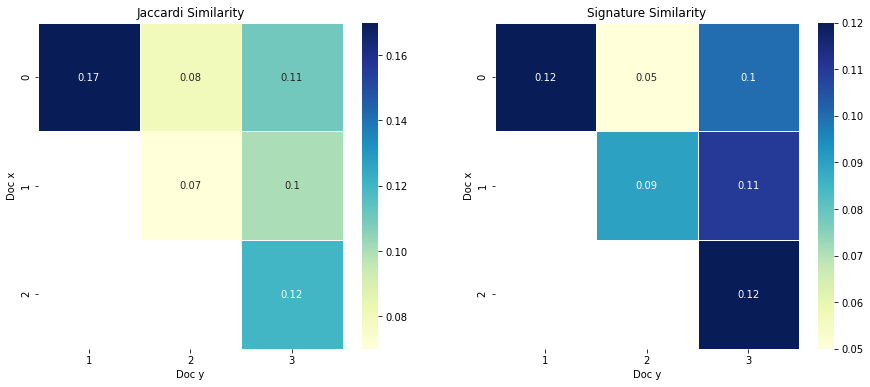

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

table = pd.pivot_table(df, values='Jaccardi Similarity', index=['Doc x'], columns=['Doc y'])
f, ax = plt.subplots(ncols=2, figsize=(15, 6))
sns.heatmap(table, annot=True, linewidths=.5, ax=ax[0], cmap="YlGnBu")

table = pd.pivot_table(df, values='Signature Similarity', index=['Doc x'], columns=['Doc y'])
sns.heatmap(table, annot=True, linewidths=.5, ax=ax[1], cmap="YlGnBu")

ax[0].set_title('Jaccardi Similarity')
ax[1].set_title('Signature Similarity')

In [36]:
lsh = LSH()
print(lsh.findCandidatePairs(sigMatHash, 0.60, bands=None, k=10**3))

4 documents have 0 candidate pairs
20 bands and 5 rows per band
Estimated similarity threshold: 0.5492802716530588
[]


## Test some documents...

In [37]:
with open('./documents/bigdataprocessing.txt', 'r', encoding="utf8") as f:
    f1 = f.readlines()

with open('./documents/deeplearning.txt', 'r', encoding="utf8") as f:
    f2 = f.readlines()

with open('./documents/mmds.txt', 'r', encoding="utf8") as f:
    f3 = f.readlines()

with open('./documents/operatingsystems.txt', 'r', encoding="utf8") as f:
    f4 = f.readlines()

bigdataprocessing, deeplearning, mmds, operatingsystems = '', '', '', ''
for substring in f1:
  bigdataprocessing += substring

for substring in f2:
  deeplearning += substring

for substring in f3:
  mmds += substring

for substring in f4:
  operatingsystems += substring

documents = [bigdataprocessing, mmds, operatingsystems, deeplearning]


print(len(bigdataprocessing))
print(len(deeplearning))
print(len(mmds))
print(len(operatingsystems))

225519
179951
822938
766417


In [38]:
shingle_length = 5

hashed_shingles = []

for doc in documents:
    hashed_shingles.append(Shingling(doc, shingle_length).hashed_shingles)

vocabulary = set().union(*hashed_shingles)

for i, hs in enumerate(hashed_shingles):
    print("Length of document #{}:".format(i), len(hs))

Length of document #0: 47359
Length of document #1: 65724
Length of document #2: 31088
Length of document #3: 41593


In [39]:
import time

# ----- Creating Signature Matrix with Hashing -----
minHash = MinHashing()
number_of_hash_functions = 100

start = time.time()

sigMatHash = minHash.createSigMatHash(hashed_shingles, number_of_hash_functions)

end = time.time()
print('Time elapsed Hash:', end - start)
pd.DataFrame(sigMatHash)

Time elapsed Hash: 68.14126420021057


,0,1,2,3
0,68033,68033,66159,195683
1,92549,523579,611801,125482
2,152003,60778,27004,79367
3,291851,50738,93251,128922
4,1483,1483,53034,53034
...,...,...,...,...
95,31132,31132,44646,44646
96,18762,18762,18762,18762
97,163781,163781,163781,12169
98,288240,370712,31451,43437


In [40]:
comparer = CompareSets()
signature_comparer = CompareSignatures()

jaccardi = []

for i, a in enumerate(hashed_shingles):
    for j, b in enumerate(hashed_shingles):
        if (a != b) and (i < j):
            #print("Jaccard similarity between documents {} and {} is {}".format(i, j, round(comparer.similarity(a, b), 2)))
            jaccardi.append((i, j, round(comparer.similarity(a, b), 2), signature_comparer.similarity(sigMatHash[:,i], sigMatHash[:,j])))
            #print("MinHash similarity between documents {} and {} is {}".format(a, b, comparer.minhash_similarity(sigMat[a], sigMat[b])))

df = pd.DataFrame(jaccardi, columns=['Doc x', 'Doc y', 'Jaccardi Similarity', 'Signature Similarity'], index=None)
df

,Doc x,Doc y,Jaccardi Similarity,Signature Similarity
0,0,1,0.36,0.33
1,0,2,0.21,0.17
2,0,3,0.21,0.20
3,1,2,0.19,0.19
4,1,3,0.19,0.18
5,2,3,0.19,0.26


Text(0.5, 1.0, 'Signature Similarity')

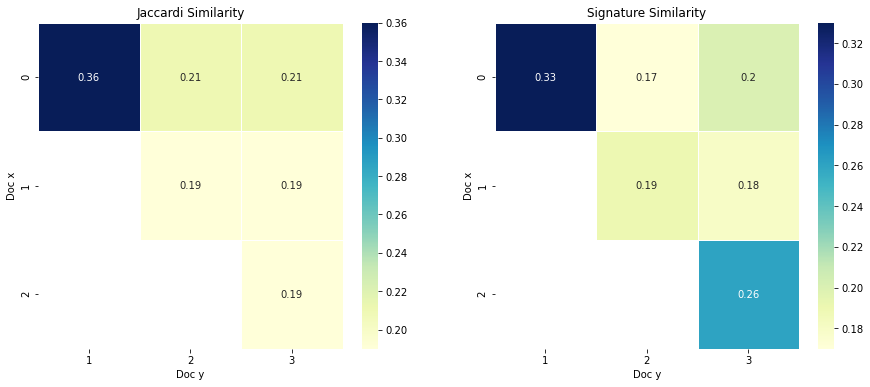

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

table = pd.pivot_table(df, values='Jaccardi Similarity', index=['Doc x'], columns=['Doc y'])
f, ax = plt.subplots(ncols=2, figsize=(15, 6))
sns.heatmap(table, annot=True, linewidths=.5, ax=ax[0], cmap="YlGnBu")

table = pd.pivot_table(df, values='Signature Similarity', index=['Doc x'], columns=['Doc y'])
sns.heatmap(table, annot=True, linewidths=.5, ax=ax[1], cmap="YlGnBu")

ax[0].set_title('Jaccardi Similarity')
ax[1].set_title('Signature Similarity')

In [42]:
lsh = LSH()
print(lsh.findCandidatePairs(sigMatHash, 0.30, bands=None, k=10**3))

4 documents have 1 candidate pairs
25 bands and 4 rows per band
Estimated similarity threshold: 0.4472135954999579
[(0, 1)]
